In [36]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tqdm import tqdm
import image_slicer
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

print('Libraries Loaded')

Libraries Loaded


## Utilies

In [24]:
def read_imgs(path):
    img,names = [],[]
    for i in sorted(os.listdir(path)):
        names.append(i)
        img.append(cv2.imread(os.path.join(path,i)))
    return names,np.array(img)

def visualize(in_images,out_images,number):
    for i in number:
        plt.subplot(121)
        plt.imshow(in_images[i])
        plt.title('Original')
        
        plt.subplot(122)
        plt.imshow(out_images[i])
        plt.title('Output')
        
        plt.show()

## Main

In [3]:
## Folders
root = r'C:\Users\saad\Desktop\Image-Background-Removal\COCO Dataset\COCOdataset2017'
annotations = r'annotations'
images = r'images'
pre_imgs = r'Preprocesed_images'

## Training
train_img = 'train'
train_ann = 'instances_train.json'
train_process = 'train_images'

## Validation
val_img = r'val'
val_ann = r'instances_val.json'
val_img_process = 'val_images'
val_ann_process = 'val_ann'


In [25]:
input_name,input_images = read_imgs(os.path.join(root,pre_imgs,val_img_process))
print('Input images done')
output_name,output_images = read_imgs(os.path.join(root,pre_imgs,val_ann_process))
print('Output images done')

Input images done
Output images done


In [43]:
input_processed = input_images/255.
output_processed = output_images[:,:,:,:1]/255.
output_processed[output_processed>=0.5] = 1
output_processed[output_processed<0.5] = 0

print(f'The shape of the input_process is {input_processed.shape} and the shape of output_processed is {output_processed.shape}')

The shape of the input_process is (2693, 224, 224, 3) and the shape of output_processed is (2693, 224, 224, 1)


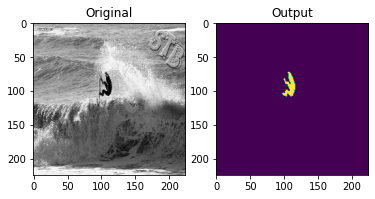

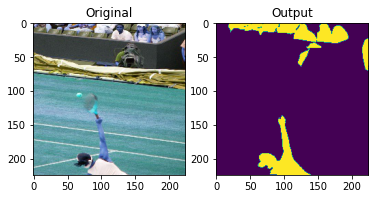

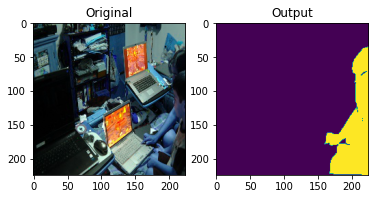

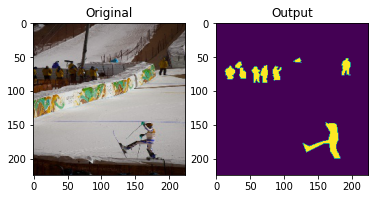

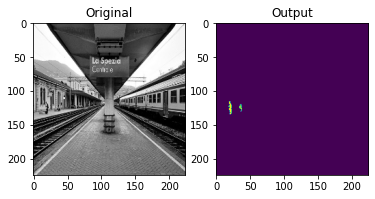

In [44]:
num = random.sample(range(0,len(input_processed)),5)
visualize(input_processed,output_processed,num)

In [38]:
x_train,x_test,y_train,y_test = train_test_split(input_processed,output_processed,test_size=0.2,random_state=42)

print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is (2154, 224, 224, 3) and the shape of y_train is (2154, 224, 224, 1)
The shape of x_test is (539, 224, 224, 3) and the shape of y_test is (539, 224, 224, 1)


### Model

In [39]:
filepath = 'unet_coco.hdf5'
checkpoint =keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)

In [46]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

n_epochs = 1

in1 = Input(shape=(224,224, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
segmentation = Conv2D(1,(1, 1),activation='sigmoid', name='seg')(conv7)

model = Model(inputs=[in1], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'
    }

metrics = {'seg': ['acc']
        }
model.compile(optimizer="RMSprop", loss = losses, metrics=metrics)

model.summary()


# Start the training process
history = model.fit(x_train,y_train,validation_split=0.2,batch_size=32,epochs=200,callbacks=[checkpoint])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

54/54 [==============================] - 10s 190ms/step - loss: 0.3991 - acc: 0.8277 - val_loss: 0.4100 - val_acc: 0.8414
Epoch 8/200
54/54 [==============================] - 10s 192ms/step - loss: 0.3939 - acc: 0.8278 - val_loss: 0.3606 - val_acc: 0.8416
Epoch 9/200
54/54 [==============================] - 10s 191ms/step - loss: 0.3908 - acc: 0.8283 - val_loss: 0.3501 - val_acc: 0.8462
Epoch 10/200
54/54 [==============================] - 10s 189ms/step - loss: 0.3800 - acc: 0.8312 - val_loss: 0.3537 - val_acc: 0.8437
Epoch 11/200
54/54 [==============================] - 10s 190ms/step - loss: 0.3706 - acc: 0.8344 - val_loss: 0.3462 - val_acc: 0.8494
Epoch 12/200
54/54 [==============================] - 10s 191ms/step - loss: 0.3645 - acc: 0.8380 - val_loss: 0.3438 - val_acc: 0.8537
Epoch 13/200
54/54 [==============================] - 10s 190ms/step - loss: 0.3651 - acc: 0.8368 - val_loss: 0.3321 - val_acc: 0.8553
Epoch 14/200
54/54 [==============================] - 10s 190ms/step -

54/54 [==============================] - 10s 190ms/step - loss: 0.1912 - acc: 0.9198 - val_loss: 0.3267 - val_acc: 0.8494
Epoch 68/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1965 - acc: 0.9170 - val_loss: 0.3007 - val_acc: 0.8806
Epoch 69/200
54/54 [==============================] - 10s 188ms/step - loss: 0.1851 - acc: 0.9225 - val_loss: 0.3568 - val_acc: 0.8812
Epoch 70/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1873 - acc: 0.9211 - val_loss: 0.3520 - val_acc: 0.8795
Epoch 71/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1861 - acc: 0.9226 - val_loss: 0.3201 - val_acc: 0.8746
Epoch 72/200
54/54 [==============================] - 10s 188ms/step - loss: 0.1886 - acc: 0.9216 - val_loss: 0.2988 - val_acc: 0.8694
Epoch 73/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1807 - acc: 0.9256 - val_loss: 0.3256 - val_acc: 0.8837
Epoch 74/200
54/54 [==============================] - 10s 189ms/step

54/54 [==============================] - 10s 189ms/step - loss: 0.1140 - acc: 0.9562 - val_loss: 0.4717 - val_acc: 0.8781
Epoch 128/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1165 - acc: 0.9545 - val_loss: 0.4083 - val_acc: 0.8643
Epoch 129/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1111 - acc: 0.9568 - val_loss: 0.4277 - val_acc: 0.8697
Epoch 130/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1112 - acc: 0.9569 - val_loss: 0.3849 - val_acc: 0.8781
Epoch 131/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1188 - acc: 0.9539 - val_loss: 0.3599 - val_acc: 0.8797
Epoch 132/200
54/54 [==============================] - 10s 190ms/step - loss: 0.1082 - acc: 0.9584 - val_loss: 0.3965 - val_acc: 0.8815
Epoch 133/200
54/54 [==============================] - 10s 189ms/step - loss: 0.1011 - acc: 0.9607 - val_loss: 0.4094 - val_acc: 0.8825
Epoch 134/200
54/54 [==============================] - 10s 189

54/54 [==============================] - 10s 189ms/step - loss: 0.0902 - acc: 0.9651 - val_loss: 0.4311 - val_acc: 0.8764
Epoch 188/200
54/54 [==============================] - 10s 189ms/step - loss: 0.0892 - acc: 0.9654 - val_loss: 0.4338 - val_acc: 0.8739
Epoch 189/200
54/54 [==============================] - 10s 190ms/step - loss: 0.0809 - acc: 0.9688 - val_loss: 0.4641 - val_acc: 0.8654
Epoch 190/200
54/54 [==============================] - 10s 189ms/step - loss: 0.0872 - acc: 0.9664 - val_loss: 0.4565 - val_acc: 0.8596
Epoch 191/200
54/54 [==============================] - 10s 189ms/step - loss: 0.0893 - acc: 0.9656 - val_loss: 0.4679 - val_acc: 0.8791
Epoch 192/200
54/54 [==============================] - 10s 190ms/step - loss: 0.0848 - acc: 0.9669 - val_loss: 0.4581 - val_acc: 0.8759
Epoch 193/200
54/54 [==============================] - 10s 189ms/step - loss: 0.0938 - acc: 0.9647 - val_loss: 0.4517 - val_acc: 0.8799
Epoch 194/200
54/54 [==============================] - 10s 190

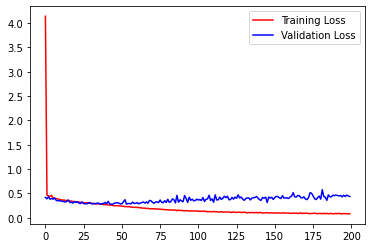

In [47]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

In [52]:
model.load_weights(filepath)
predictions = model.predict(x_test)
predictions.shape

(539, 224, 224, 1)

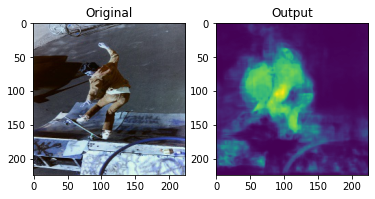

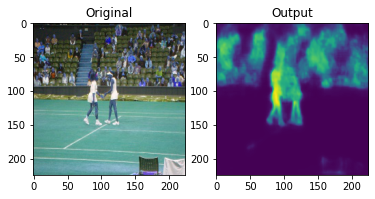

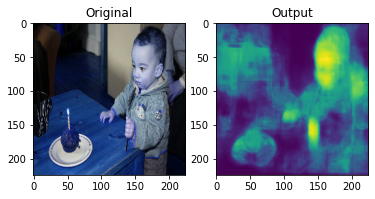

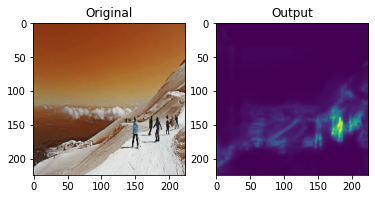

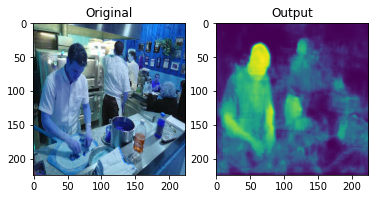

In [53]:
visualize(x_test,predictions,[1,2,3,4,5])